# Object Detection with Yolo'v2 for PASCAL VOC 2012 dataset

Mina Rahmanian 

---




In [ ]:
'''''''''''''''''''''''''''''''''''''''''''''' ** Anchor box & input and output ** '''''''''''''''''''''''''''''''''''''''''''

In [ ]:
cd /content/drive/My Drive/YOLO-objectdetection-Mina

/content/drive/My Drive/YOLO-objectdetection-Mina


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
import tensorflow
import numpy as np

In [ ]:
# Download dataset directly from website and then untar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar -O ./voc2012_raw.tar
!mkdir -p ./voc2012_raw
!tar -xf ./voc2012_raw.tar -C ./voc2012_raw

--2020-03-30 01:04:52--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘./voc2012_raw.tar’

./voc2012_raw.tar   100%[===================>]   1.86G  4.37MB/s    in 7m 18s  

2020-03-30 01:12:11 (4.35 MB/s) - ‘./voc2012_raw.tar’ saved [1999639040/1999639040]



In [ ]:
!ls

import tensorflow as tf
tf.__version__

In [ ]:
# 20 type of labels/class name in VOC2012 dataset that exists
LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
# Saved VOC2012 dataset in 
train_image_folder = "/content/drive/My Drive/YOLO-objectdetection-Mina/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "/content/drive/My Drive/YOLO-objectdetection-Mina/voc2012_raw/VOCdevkit/VOC2012/Annotations/"

In [ ]:
import matplotlib.pyplot as plt # for plotting
import numpy as np # an alias for the namespace will be created in functions that are in the numpy module 
import os, cv2 #  OpenCV releases two types of Python interfaces, cv and cv2
import sys # import the relevant to the system of my computer, allowing your Python program to interact with it in a broader way.
print(sys.version)
%matplotlib inline

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [ ]:
# Preprocess the Annotations  - https://github.com/experiencor/keras-yolo2
import xml.etree.ElementTree as ET  # module implements a simple and efficient API for parsing and creating XML data

def parse_annotation(ann_dir, img_dir, labels=[]):

    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)): # Return a list containing the names of the entries in the directory given by ann_dir (ann_dir : This is the directory, which needs to be explored).
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann) # Reading the data from (ann_dir + ann)
        
        for elem in tree.iter(): # Element has some useful methods that help iterate recursively over all the sub-tree below it,e.g Element.iter()
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                # Image exists
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image) # Assert keyword lets you test if a condition in your code returns True, if not, the program will raise an AssertionError.
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels


In [ ]:
# Preprocess annotations 
np.random.seed(10)
train_image = []
seen_train_labels = {}

train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("Number of image for train = {}".format(len(train_image)))

'''
   - Each of the train_image is a dictionary containing the annoation infomation of an image.
   - seen_train_labels is the dictionary containing (key, value) = (object class, number of objects found in the images)
'''
# Number of image for train = 17125

Number of image for train = 17125


'\n   - Each of the train_image is a dictionary containing the annoation infomation of an image.\n   - seen_train_labels is the dictionary containing (key, value) = (object class, number of objects found in the images)\n'

In [ ]:
#train_image[:1]

In [ ]:
import copy

class ImageReader(object): # first step of input and output encoding

    def __init__(self,IMAGE_H,IMAGE_W, norm=None):

        self.IMAGE_H = IMAGE_H # the height of the rescaled image, e.g 416
        self.IMAGE_W = IMAGE_W # the width of the rescaled image, e.g 416
        self.norm    = norm
        
    def encode_core(self,image, reorder_rgb=True): # resize the image to standard size     
        
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)
        return(image)
    
    def fit(self,train_instance): # read in and resize the image, annotations are resized accordingly.
                                  # train_instance : dictionary containing filename, height, width and object

        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}
                
        image_name = train_instance['filename']
        image = cv2.imread(image_name) # cv2.imread() : A library of Python bindings designed to solve computer vision problems. loads an image from the image_name.
        h, w, c = image.shape 
        if image is None: print('Cannot find ', image_name)
      
        image = self.encode_core(image, reorder_rgb=True)
            
        if "object" in train_instance.keys():
            
            all_objs = copy.deepcopy(train_instance['object'])     

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

******************************
Input
  object: [{'name': 'horse', 'xmin': 100, 'ymin': 96, 'xmax': 355, 'ymax': 324}, {'name': 'person', 'xmin': 198, 'ymin': 58, 'xmax': 286, 'ymax': 197}]
  filename: /content/drive/My Drive/YOLO-objectdetection-Mina/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/2007_000392.jpg
  width: 500
  height: 332
******************************
Output
          [{'name': 'horse', 'xmin': 83, 'ymin': 120, 'xmax': 295, 'ymax': 405}, {'name': 'person', 'xmin': 164, 'ymin': 72, 'xmax': 237, 'ymax': 246}]


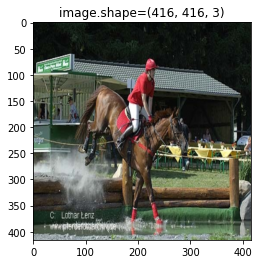

In [ ]:
# e.g of Input and output encoder 25th image

def normalize(image): # Normalize the image
    return image / 255.

print("*"*30)
print("Input")
timage = train_image[25]
for key, v in timage.items():
    print("  {}: {}".format(key,v))
    
print("*"*30)
print("Output")
inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(timage)
print("          {}".format(all_objs))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

# original image is size - input (332,500,3). xmin, xmax, ymin and ymax is for two class (100,96,355,324) & (198,58,286,197)
# encoded image is of shape - output (416,416,3). xmin, xmax, ymin and ymax is for two class (83,120,295,405) & (164,72,237,246)


In [ ]:
#  Find the best anchor boxes from between two anchor boxes

class BestAnchorBoxFinder(object): # find best anchore box in this class


    def __init__(self, ANCHORS): #  ANCHORS: a np.array of even number length

        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS)//2))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2): # bound boxing by using IOU 
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):  # find the anchor that best predicts this box
       
        best_anchor = -1
        max_iou     = -1
        # each Anchor box have a certain shape. flat, large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        
        for i in range(len(self.anchors)): # run through each anchor box
            anchor = self.anchors[i]
            iou    = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou     = iou
        return(best_anchor,max_iou)    
    
    
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):

        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        self.confidence      = confidence # probability
        self.set_class(classes)  # class probaiblities [c1, c2, .. c Nclass]
        
    def set_class(self,classes):
        self.classes = classes
        self.label   = np.argmax(self.classes) #  probaiblities [c1, c2, .. c Nclass]
        
    def get_label(self):  
        return(self.label)
    
    def get_score(self):
        return(self.classes[self.label])

In [ ]:
#  e.g of using four anchor boxes (width and height)

_ANCHORS01 = np.array([0.08285376, 0.13705531, # tiny anchor box
                       0.20850361, 0.39420716, # small anchor box
                       0.80552421, 0.77665105, # large anchor box
                       0.42194719, 0.62385487]) # medium tall anchor box

print(".."*40)
print("The three example anchor boxes:")
count = 0


for i in range(0,len(_ANCHORS01),2):
    print("anchor box index={}, w={}, h={}".format(count,_ANCHORS01[i],_ANCHORS01[i+1]))
    count += 1

    
print(".."*40)   
print("Allocate bounding box of various width and height into the three anchor boxes:")  
babf = BestAnchorBoxFinder(_ANCHORS01)


for w in range(1,9,2):
    w /= 10.
    for h in range(1,9,2):
        h /= 10.
        best_anchor,max_iou = babf.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(w,h,best_anchor,max_iou))
       

................................................................................
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
................................................................................
Allocate bounding box of various width and height into the three anchor boxes:
bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3

In [ ]:

def rescale_centerxy(obj,config): # obj: dictionary (xmin, xmax, ymin, ymax)
                                  # config: dictionary (IMAGE_W, GRID_W, IMAGE_H and GRID_H)

    center_x = .5*(obj['xmin'] + obj['xmax']) # 1/2 * (xmin + xmax)
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W']) 

    center_y = .5*(obj['ymin'] + obj['ymax']) # 1/2 * (ymin + ymax)
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_x,center_y)

def rescale_cebterwh(obj,config): # YOLO devides an image into grid cells (e.g. 13 by 13 grid cells)
 
    # unit: grid cell 
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W']) # (xmax - xmin)
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H']) # (ymax - ymin)
    return(center_w,center_h)

In [ ]:
# e.g of rescale_center xy and rescale_center wh

obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13} # GRID_W & GRID_H are ranging between [0, N grid h)

center_x, center_y = rescale_centerxy(obj,config)
center_w, center_h = rescale_cebterwh(obj,config)

print("cebter_x abd cebter_w should range between 0 and {}".format(config["GRID_W"]))
print("cebter_y abd cebter_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))


cebter_x abd cebter_w should range between 0 and 13
cebter_y abd cebter_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


In [ ]:
from keras.utils import Sequence # Base object for fitting to a sequence of data, such as a dataset.

class SimpleBatchGenerator(Sequence): # create a Keras's batch generator by combining all the input and output encoding


    def __init__(self, images, config, norm=None, shuffle=True): # config : dictionary containing necessary hyper parameters for traning

        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle

        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    

    def __getitem__(self, idx): # idx : non-negative integer value

        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        

        ## prepare empty storage space: this will be output
        # x_batch: The numpy array of shape (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)
        # b_batch: The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)
        # y_batch: The numpy array of shape (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes)
        # BOX = The number of anchor boxes.
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))  # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))   # list of self.config['TRUE_self.config ['BOX']_BUFFER'] GT boxes
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))  # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_cebterwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)
                                
                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such ase, the object is over written
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object


                        b_batch[instance_count, 0, 0, 0, true_box_index] = box # assign the true box to b_batch
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            instance_count += 1  # increase instance counter in current batch

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

Using TensorFlow backend.


In [ ]:

GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01 # range between 0 and 1
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS 

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [ ]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)


In [ ]:
# input and output shape

print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [ ]:
# frame contains five objects: sofa,bottle,person,chair and person
iframe= 1
def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}, {}".format(
                        igrid_h,igrid_w,ianchor,class_nm[0]))
check_object_in_grid_anchor_pair(iframe)

igrid_h=06,igrid_w=03,iAnchor=00, dog
igrid_h=08,igrid_w=10,iAnchor=03, motorbike


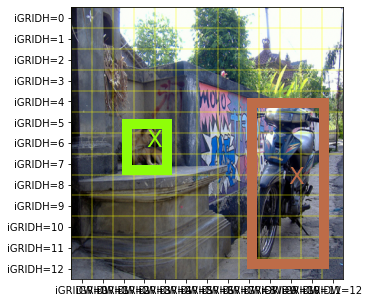

In [ ]:

def plot_image_with_grid_cell_partition(irow):

    img = x_batch[irow]
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_  = generator_config["GRID_"  + wh] ## 13
        IMAGE_  = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax = plt.axvline
            plttick = plt.xticks
        else:
            pltax = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] # ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx, np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx, np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx, np.array([ymax,ymin])*multy,color=c,linewidth=10)  
                    plt.plot(np.array([xmin,xmax])*multx, np.array([ymax,ymax])*multy,color=c,linewidth=10)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

In [ ]:
'''
# e.g
for irow in range(5,10):
    print("-"*30)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()
    
'''    

In [ ]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' ** Model ** '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

In [ ]:
# I choose 4 anchor boxes with 13 by 13 grids, every frame gets 4 x 13 x 13 = 676 boud box predict

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

In [ ]:
'''
LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',  'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
'''          

"\nLABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',  'diningtable',\n          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']\n"

In [ ]:
# YOLOv2 Model = It repeatedly  Convolusion + Batch Normalization + Relu layers until the image shape reduces to the grid cell size

from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import keras.backend as K
import tensorflow as tf



def space_to_depth_x2(x): # the function to implement the orgnization layer= 90% Keras/10% Tensorflow implementation of YOLO_v2 (github.com/allanzelener/YAD2K)
    return tf.space_to_depth(x, block_size=2)


def ConvBatchLReLu(x,filters,kernel_size,index,trainable):
    # when strides = None, strides = pool_size.
    x = Conv2D(filters, kernel_size, strides=(1,1), padding='same', name='conv_{}'.format(index), use_bias=False, trainable=trainable)(x)
    x = BatchNormalization(name='norm_{}'.format(index), trainable=trainable)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return(x)


def ConvBatchLReLu_loop(x,index,convstack,trainable):
    for para in convstack:
        x = ConvBatchLReLu(x,para["filters"],para["kernel_size"],index,trainable)
        index += 1
    return(x)


def define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, trainable=False):
    convstack3to5  = [{"filters":128, "kernel_size":(3,3)},  # 3
                      {"filters":64,  "kernel_size":(1,1)},  # 4
                      {"filters":128, "kernel_size":(3,3)}]  # 5
                    
    convstack6to8  = [{"filters":256, "kernel_size":(3,3)},  # 6
                      {"filters":128, "kernel_size":(1,1)},  # 7
                      {"filters":256, "kernel_size":(3,3)}]  # 8
    
    convstack9to13 = [{"filters":512, "kernel_size":(3,3)},  # 9
                      {"filters":256, "kernel_size":(1,1)},  # 10
                      {"filters":512, "kernel_size":(3,3)},  # 11
                      {"filters":256, "kernel_size":(1,1)},  # 12
                      {"filters":512, "kernel_size":(3,3)}]  # 13
        
    convstack14to20 = [{"filters":1024, "kernel_size":(3,3)}, # 14 
                       {"filters":512,  "kernel_size":(1,1)}, # 15
                       {"filters":1024, "kernel_size":(3,3)}, # 16
                       {"filters":512,  "kernel_size":(1,1)}, # 17
                       {"filters":1024, "kernel_size":(3,3)}, # 18
                       {"filters":1024, "kernel_size":(3,3)}, # 19
                       {"filters":1024, "kernel_size":(3,3)}] # 20
    

    input_image = Input(shape=(IMAGE_H, IMAGE_W, 3),name="input_image") # (416, 416, 3)
    true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4),name="input_hack")    
    # Layer 1
    x = ConvBatchLReLu(input_image,filters=32,kernel_size=(3,3),index=1,trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_416to208")(x)

    # Layer 2
    x = ConvBatchLReLu(x,filters=64,kernel_size=(3,3),index=2,trainable=trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_208to104")(x)
    
    # Layer (3 - 5)
    x = ConvBatchLReLu_loop(x,3,convstack3to5,trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_104to52")(x)
    
    # Layer (6 - 8)
    x = ConvBatchLReLu_loop(x,6,convstack6to8,trainable)
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_52to26")(x) 

    # Layer (9 - 13)
    x = ConvBatchLReLu_loop(x,9,convstack9to13,trainable)
        
    skip_connection = x
    x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_26to13")(x)
    
    # Layer (14 - 20)
    x = ConvBatchLReLu_loop(x,14,convstack14to20,trainable)

    # Layer 21
    skip_connection = ConvBatchLReLu(skip_connection,filters=64, kernel_size=(1,1),index=21,trainable=trainable)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = ConvBatchLReLu(x,filters=1024,kernel_size=(3,3),index=22,trainable=trainable)

    # Layer 23
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS),name="final_output")(x)


    output = Lambda(lambda args: args[0],name="hack_layer")([output, true_boxes])

    model = Model([input_image, true_boxes], output)
    return(model, true_boxes)



IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
CLASS             = len(LABELS)
## true_boxes is the tensor that takes "b_batch"
model, true_boxes = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,BOX,CLASS, trainable=False)

model.summary()













Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 32) 0           norm_1[0][0]                     
________________________________________________________________________________

In [ ]:
cd /content/drive/My Drive/YOLO-objectdetection-Mina

/content/drive/My Drive/YOLO-objectdetection-Mina


In [ ]:
# Download pretrained weigth yolo2 from website
!wget https://pjreddie.com/media/files/yolov2.weights

--2020-03-30 01:25:43--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M   539KB/s    in 7m 39s  

2020-03-30 01:33:24 (434 KB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [ ]:
# the wieght save in path_to_weight
path_to_weight = "./yolov2.weights"

In [ ]:

class WeightReader:
    
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
                
weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

# all_weights.shape = (50983565,)

all_weights.shape = (50983565,)


In [ ]:
# assign pre-trained weights to conv & norm layers 1,2,...,22

def set_pretrained_weight(model,nb_conv, path_to_weight):
    weight_reader = WeightReader(path_to_weight)
    weight_reader.reset()
    for i in range(1, nb_conv+1):
        conv_layer = model.get_layer('conv_' + str(i)) # conv layer

        if i < nb_conv:
            norm_layer = model.get_layer('norm_' + str(i)) # batch norm layer

            size = np.prod(norm_layer.get_weights()[0].shape)

            beta  = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean  = weight_reader.read_bytes(size)
            var   = weight_reader.read_bytes(size)

            weights = norm_layer.set_weights([gamma, beta, mean, var])       

        if len(conv_layer.get_weights()) > 1: ## with bias
            bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel, bias])
        else: ## without bias
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel])
    return(model)


nb_conv = 22
model = set_pretrained_weight(model,nb_conv, path_to_weight)

In [ ]:
# The last layer 23th - initialize weight

def initialize_weight(layer,sd):
    weights = layer.get_weights()
    new_kernel = np.random.normal(size=weights[0].shape, scale=sd)
    new_bias   = np.random.normal(size=weights[1].shape, scale=sd)
    layer.set_weights([new_kernel, new_bias])
    
layer   = model.layers[-4] # the last conv layer
initialize_weight(layer,sd=GRID_H*GRID_W)

In [ ]:
''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' ** Loss funcion of Model '''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

In [ ]:
ANCHORS = np.array([1.07709888,  1.78171903, 
                    2.71054693,  5.12469308,  
                   10.47181473, 10.09646365, 
                    5.48531347,  8.11011331]) 

In [ ]:
LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow',  'diningtable',
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

In [ ]:
train_image_folder = "/content/drive/My Drive/YOLO-objectdetection-Mina/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "/content/drive/My Drive/YOLO-objectdetection-Mina/voc2012_raw/VOCdevkit/VOC2012/Annotations/"

In [ ]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):
    

    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels

In [ ]:
# Preprocess annotations 
np.random.seed(1)
train_image = []
seen_train_labels = {}

train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("Number of image for train = {}".format(len(train_image)))


Number of image for train = 17125


In [ ]:
from keras.utils import Sequence

class SimpleBatchGenerator(Sequence):


    def __init__(self, images, config, norm=None, shuffle=True):

        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle: 
            np.random.shuffle(self.images)
            
    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))  
    
    def __getitem__(self, idx):

        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0
        
        
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3)) # input images
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))  
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS']))) # desired network output

        for train_instance in self.images[l_bound:r_bound]:
            img, all_objs = self.imageReader.fit(train_instance)
            
            # construct output from object's x, y, w, h
            true_box_index = 0
            
            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj,self.config)
                    
                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_cebterwh(obj,self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor,max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)

                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box # center_x, center_y, w, h
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1. # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1 # class probability of the object
                        
                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
                            
            x_batch[instance_count] = img
            # increase instance counter in current batch
            instance_count += 1  
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: 
            np.random.shuffle(self.images)

In [ ]:
#from keras import backend

In [ ]:
#from backend import SimpleBatchGenerator

BATCH_SIZE        = 500
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)
# CLASS             = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


def normalize(image):
    return image / 255.
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch,b_batch],y_batch = train_batch_generator.__getitem__(idx=3)

In [ ]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [ ]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX): 


    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))


    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))


    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1    
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid) 

def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):    # y_pred: takes any real values- tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
                                                            #  ANCHORS: list containing width and height specializaiton of anchor box
   
    """
  
     pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
     pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
     pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1
          
     calculation process:
     tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
     tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                              takes values between 0 and grid_H - 1 for y coordinate 
    """


    BOX = int(len(ANCHORS)/2)
    
    # adjust x and y  
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
    # adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box 
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh - shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]

    # adjust confidence 
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb - shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1

    # adjust class probabilities 
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20 - shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
    
    return(pred_box_xy,pred_box_wh,pred_box_conf,pred_box_class)

In [ ]:


def print_min_max(vec,title):
    print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))

print("*"*30)
print("prepare inputs")
GRID_W = 13 
GRID_H = 13 
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size   = BATCH_SIZE*GRID_W*GRID_H*BOX*(4 + 1 + CLASS)
y_pred = np.random.normal(size=size,scale = 10/(GRID_H*GRID_W)) 
y_pred = y_pred.reshape(BATCH_SIZE,GRID_H,GRID_W,BOX,4 + 1 + CLASS)
print("y_pred before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph")
y_pred_tf = tf.constant(y_pred,dtype="float32")
cell_grid = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
(pred_box_xy_tf,   pred_box_wh_tf, 
 pred_box_conf_tf, pred_box_class_tf) = adjust_scale_prediction(y_pred_tf, 
                                                                cell_grid, 
                                                                ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 
with tf.Session() as sess:
    (pred_box_xy,   pred_box_wh, 
     pred_box_conf, pred_box_class) = sess.run(
        [pred_box_xy_tf,   pred_box_wh_tf,
         pred_box_conf_tf, pred_box_class_tf])
    
print("\npred_box_xy {}".format(pred_box_xy.shape))           
for igrid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,igrid_w,:,0].flatten(),
                      "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,igrid_h,:,:,1].flatten(),
                  "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0].flatten(),"  bounding box width ") 
print_min_max(pred_box_wh[:,:,:,:,1].flatten(),"  bounding box height") 
    
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf.flatten(),"  confidence ") 

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class.flatten(),"  class probability") 

******************************
prepare inputs
y_pred before scaling = (500, 13, 13, 4, 25)
******************************
define tensor graph
Instructions for updating:
Use `tf.cast` instead.
******************************
ouput
******************************

pred_box_xy (500, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.44, MAX= 0.55
  bounding box x at iGRID_W=01 MIN= 1.44, MAX= 1.56
  bounding box x at iGRID_W=02 MIN= 2.44, MAX= 2.56
  bounding box x at iGRID_W=03 MIN= 3.43, MAX= 3.56
  bounding box x at iGRID_W=04 MIN= 4.44, MAX= 4.56
  bounding box x at iGRID_W=05 MIN= 5.44, MAX= 5.56
  bounding box x at iGRID_W=06 MIN= 6.44, MAX= 6.56
  bounding box x at iGRID_W=07 MIN= 7.44, MAX= 7.56
  bounding box x at iGRID_W=08 MIN= 8.44, MAX= 8.56
  bounding box x at iGRID_W=09 MIN= 9.44, MAX= 9.55
  bounding box x at iGRID_W=10 MIN=10.44, MAX=10.56
  bounding box x at iGRID_W=11 MIN=11.44, MAX=11.56
  bounding box x at iGRID_W=12 MIN=12.44, MAX=12.56
  bounding box y at iGRID_H=00 

In [ ]:

def extract_ground_truth(y_true):    
    true_box_xy    = y_true[..., 0:2] # bound box x, y coordinate in grid cell scale 
    true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    true_box_conf  = y_true[...,4]    # confidence 
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [ ]:
# y_batch is the output of the simpleBatchGenerator.fit()
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy_tf, true_box_wh_tf, 
 true_box_conf_tf, true_box_class_tf) = extract_ground_truth(y_batch_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

with tf.Session() as sess:
        (true_box_xy, true_box_wh, 
         true_box_conf, true_box_class) = sess.run(
                    [true_box_xy_tf,   true_box_wh_tf, 
                     true_box_conf_tf, true_box_class_tf])

print("\ntrue_box_xy {}".format(true_box_xy.shape))        
for igrid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,igrid_w,:,0].flatten()
    pick = true_box_conf[:,:,igrid_w,:].flatten() == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,igrid_h,:,:,1].flatten()
    pick = true_box_conf[:,igrid_h,:,:].flatten() == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
    
print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,:,0].flatten(),"  bounding box width ") 
print_min_max(true_box_wh[:,:,:,:,1].flatten(),"  bounding box height") 
    
print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  confidence, unique value = {}".format(np.unique(true_box_conf.flatten()))) 

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class.flatten())) )

Input y_batch = (500, 13, 13, 4, 25)
******************************
ouput
******************************

true_box_xy (500, 13, 13, 4, 2)
  bounding box x at iGRID_W=00 MIN= 0.17, MAX= 0.94
  bounding box x at iGRID_W=01 MIN= 1.00, MAX= 1.97
  bounding box x at iGRID_W=02 MIN= 2.02, MAX= 2.98
  bounding box x at iGRID_W=03 MIN= 3.03, MAX= 3.97
  bounding box x at iGRID_W=04 MIN= 4.02, MAX= 4.98
  bounding box x at iGRID_W=05 MIN= 5.00, MAX= 5.98
  bounding box x at iGRID_W=06 MIN= 6.00, MAX= 6.98
  bounding box x at iGRID_W=07 MIN= 7.00, MAX= 7.98
  bounding box x at iGRID_W=08 MIN= 8.02, MAX= 8.98
  bounding box x at iGRID_W=09 MIN= 9.02, MAX= 9.98
  bounding box x at iGRID_W=10 MIN=10.00, MAX=10.97
  bounding box x at iGRID_W=11 MIN=11.00, MAX=11.98
  bounding box x at iGRID_W=12 MIN=12.00, MAX=12.84
  bounding box y at iGRID_H=00 MIN= 0.41, MAX= 0.92
  bounding box y at iGRID_H=01 MIN= 1.02, MAX= 1.80
  bounding box y at iGRID_H=02 MIN= 2.00, MAX= 2.97
  bounding box y at iGRID_H=03

In [ ]:
# calculate the loss specific to the bounding box parameters
def calc_loss_xywh(true_box_conf,
                   COORD_SCALE,
                   true_box_xy, pred_box_xy,true_box_wh,pred_box_wh):  

    # lambda_{coord} L_{i,j}^{obj} 
    # np.array of shape (Nbatch, Ngrid h, N grid w, N anchor, 1)
    coord_mask  = tf.expand_dims(true_box_conf, axis=-1) * COORD_SCALE 
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    loss_xy      = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh      = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    return(loss_xy + loss_wh, coord_mask)

In [ ]:
# calc_loss_xywh

LAMBDA_COORD = 1
loss_xywh_tf, coord_mask_tf  = calc_loss_xywh(true_box_conf_tf,LAMBDA_COORD,
                                              true_box_xy_tf, pred_box_xy_tf,
                                              true_box_wh_tf,pred_box_wh_tf)

print("*"*30 + "\nouput\n" + "*"*30) 

with tf.Session() as sess:
        loss_xywh = sess.run([loss_xywh_tf])[0]
print("loss_xywh = {:4.3f}".format(loss_xywh))

******************************
ouput
******************************
loss_xywh = 3.281


In [ ]:

def calc_loss_class(true_box_conf,CLASS_SCALE, true_box_class,pred_box_class): #    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
                                                                               # true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
                                                                               # pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
                                                                               # CLASS_SCALE    : 1.0
   
    class_mask   = true_box_conf  * CLASS_SCALE # L_{i,j}^obj * lambda_class
    
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, 
                                                                  logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)   
    return(loss_class)

    '''
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1 
    else: 
        0 
    '''

In [ ]:
LAMBDA_CLASS   = 1
loss_class_tf  = calc_loss_class(true_box_conf_tf,LAMBDA_CLASS,
                                 true_box_class_tf,pred_box_class_tf)
print("*"*30 + "\nouput\n" + "*"*30) 
with tf.Session() as sess:
        loss_class = sess.run(loss_class_tf)
print("loss_class = {:4.3f}".format(loss_class))

******************************
ouput
******************************
loss_class = 3.000


In [ ]:
def get_intersect_area(true_xy,true_wh,pred_xy,pred_wh): #  true_xy,pred_xy, true_wh and pred_wh must have the same shape length


    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half #(px1,py1)
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)    
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf,
                                true_box_xy, true_box_wh,
                                pred_box_xy,  pred_box_wh):# true_box_conf: tensor of shape (N batch, N grid h, N grid w, N anchor )
                                                            # true_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
                                                            # true_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
                                                            # pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
                                                            # pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    '''  
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    
    iou_scores        =  get_intersect_area(true_box_xy,true_box_wh,
                                            pred_box_xy,pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf # true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)


    return(true_box_conf_IOU)
    

In [ ]:
true_box_conf_IOU_tf = calc_IOU_pred_true_assigned(
                            true_box_conf_tf,
                            true_box_xy_tf, true_box_wh_tf,
                            pred_box_xy_tf,  pred_box_wh_tf)
with tf.Session() as sess:
    true_box_conf_IOU = sess.run(true_box_conf_IOU_tf)
print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_conf_tf = {}".format(true_box_conf_tf))
print("true_box_xy_tf   = {}".format(true_box_xy_tf))
print("true_box_wh_tf   = {}".format(true_box_wh_tf))
print("pred_box_xy_tf   = {}".format(pred_box_xy_tf))
print("pred_box_wh_tf   = {}".format(pred_box_wh_tf))
print("*"*30 + "\nouput\n" + "*"*30) 
print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))



'''
vec  = true_box_conf_IOU.flatten()
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()
'''

******************************
input
******************************
true_box_conf_tf = Tensor("strided_slice_6:0", shape=(500, 13, 13, 4), dtype=float32)
true_box_xy_tf   = Tensor("strided_slice_4:0", shape=(500, 13, 13, 4, 2), dtype=float32)
true_box_wh_tf   = Tensor("strided_slice_5:0", shape=(500, 13, 13, 4, 2), dtype=float32)
pred_box_xy_tf   = Tensor("add:0", shape=(500, 13, 13, 4, 2), dtype=float32)
pred_box_wh_tf   = Tensor("mul:0", shape=(500, 13, 13, 4, 2), dtype=float32)
******************************
ouput
******************************
true_box_conf_IOU.shape = (500, 13, 13, 4)


'\nvec  = true_box_conf_IOU.flatten()\npick = vec!=0\nvec  = vec[pick]\nplt.hist(vec)\nplt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick),\n                                                             100*np.mean(pick)))\nplt.xlabel("nonzero true_box_conf_IOU")\nplt.show()\n'

In [ ]:
def calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes):   # pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
                                                                   # pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
                                                                   # true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)

    true_xy = true_boxes[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = true_boxes[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    
    pred_xy = tf.expand_dims(pred_box_xy, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4) # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    
    iou_scores  =  get_intersect_area(true_xy,
                                      true_wh,
                                      pred_xy,
                                      pred_wh) # (N batch, N grid_h, N grid_w, N anchor, 50)   

    best_ious = tf.reduce_max(iou_scores, axis=4) # (N batch, N grid_h, N grid_w, N anchor)
    return(best_ious)
    


In [ ]:
true_boxes_tf = tf.constant(b_batch,dtype="float32")
best_ious_tf = calc_IOU_pred_true_best(pred_box_xy_tf,
                                       pred_box_wh_tf,
                                       true_boxes_tf)
with tf.Session() as sess:
    best_ious = sess.run(best_ious_tf)
    
print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_wh_tf   = {}".format(true_box_wh_tf))
print("pred_box_xy_tf   = {}".format(pred_box_xy_tf))
print("pred_box_wh_tf   = {}".format(pred_box_wh_tf))
print("*"*30 + "\nouput\n" + "*"*30) 
print("best_ious.shape = {}".format(best_ious.shape))

'''
vec  = best_ious.flatten()
pick = vec!=0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),
                                                             100*np.mean(pick)))
plt.xlabel("nonzero best_ious")
plt.show()
'''

******************************
input
******************************
true_box_wh_tf   = Tensor("strided_slice_5:0", shape=(500, 13, 13, 4, 2), dtype=float32)
pred_box_xy_tf   = Tensor("add:0", shape=(500, 13, 13, 4, 2), dtype=float32)
pred_box_wh_tf   = Tensor("mul:0", shape=(500, 13, 13, 4, 2), dtype=float32)
******************************
ouput
******************************
best_ious.shape = (500, 13, 13, 4)


'\nvec  = best_ious.flatten()\npick = vec!=0\nvec  = vec[pick]\nplt.hist(vec)\nplt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),\n                                                             100*np.mean(pick)))\nplt.xlabel("nonzero best_ious")\nplt.show()\n'

In [ ]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT):   
  
# best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
# true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
# true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
# LAMBDA_NO_OBJECT    : 1.0
# LAMBDA_OBJECT       : 5.0


# conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)       
    conf_mask = tf.to_float(best_ious < 0.6) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return(conf_mask)

In [ ]:
conf_mask_tf = get_conf_mask(best_ious_tf, 
                             true_box_conf_tf, 
                             true_box_conf_IOU_tf,
                             LAMBDA_NO_OBJECT, 
                             LAMBDA_OBJECT)
print("*"*30 + "\ninput\n" + "*"*30)  
print("best_ious         = {}".format(best_ious_tf)) 
print("true_box_conf     = {}".format(true_box_conf_tf))
print("true_box_conf_IOU = {}".format(true_box_conf_IOU_tf))
print("LAMBDA_NO_OBJECT  = {}".format(LAMBDA_NO_OBJECT)) 
print("LAMBDA_OBJECT     = {}".format(LAMBDA_OBJECT))
with tf.Session() as sess:
    conf_mask = sess.run(conf_mask_tf)
print("*"*30 + "\noutput\n" + "*"*30)      
print("conf_mask shape = {}".format(conf_mask.shape))

******************************
input
******************************
best_ious         = Tensor("Max:0", shape=(500, 13, 13, 4), dtype=float32)
true_box_conf     = Tensor("strided_slice_6:0", shape=(500, 13, 13, 4), dtype=float32)
true_box_conf_IOU = Tensor("mul_9:0", shape=(500, 13, 13, 4), dtype=float32)
LAMBDA_NO_OBJECT  = 1.0
LAMBDA_OBJECT     = 5.0
******************************
output
******************************
conf_mask shape = (500, 13, 13, 4)


In [ ]:
def calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf):  
    '''
    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''

    
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # Number of conf
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    return(loss_conf)

In [ ]:
print("*"*30 + "\ninput\n" + "*"*30)  
print("conf_mask_tf         = {}".format(conf_mask_tf)) 
print("true_box_conf_IOU_tf = {}".format(true_box_conf_IOU_tf))
print("pred_box_conf_tf     = {}".format(pred_box_conf_tf))

loss_conf_tf = calc_loss_conf(conf_mask_tf,true_box_conf_IOU_tf, pred_box_conf_tf)
with tf.Session() as sess:
    loss_conf = sess.run(loss_conf_tf) 
    
print("*"*30 + "\noutput\n" + "*"*30)      
print("loss_conf = {:5.4f}".format(loss_conf))

******************************
input
******************************
conf_mask_tf         = Tensor("add_11:0", shape=(500, 13, 13, 4), dtype=float32)
true_box_conf_IOU_tf = Tensor("mul_9:0", shape=(500, 13, 13, 4), dtype=float32)
pred_box_conf_tf     = Tensor("Sigmoid_1:0", shape=(500, 13, 13, 4), dtype=float32)
******************************
output
******************************
loss_conf = 0.1249


In [ ]:
########################
def custom_loss_core(y_true,
                     y_pred,
                     true_boxes,
                     GRID_W,
                     GRID_H,
                     BATCH_SIZE,
                     ANCHORS,
                     LAMBDA_COORD,
                     LAMBDA_CLASS,
                     LAMBDA_NO_OBJECT, 
                     LAMBDA_OBJECT):

    BOX = int(len(ANCHORS)/2)    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    # Step 5: For each (grid cell, anchor) pair, 
    # calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    # calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
    
    loss = loss_xywh + loss_conf + loss_class
    return(loss)

In [ ]:
def custom_loss(y_true, y_pred): # y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
 

    total_recall = tf.Variable(0.)
    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)

    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)

    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                  true_box_class,pred_box_class)
    
    # Step 5: For each (grid cell, anchor) pair, 
    # calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    # calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.

    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)

    
    loss = loss_xywh + loss_conf + loss_class
    

    
    return loss

In [ ]:
true_boxes = tf.Variable(np.zeros_like(b_batch),dtype="float32")
loss_tf    = custom_loss(y_batch_tf, y_pred_tf) 
with tf.Session() as sess:
    loss = sess.run(loss_tf,
                    feed_dict = {true_boxes: b_batch})
loss

6.4061117

In [ ]:
''''''''''''''''''''''''''''''''''''''  Part 4 ''''''''''''''''''''''''''''''''''''''''''''''

In [ ]:
from numpy import *
import numpy as np

In [ ]:
ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

In [ ]:
LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

In [ ]:
train_image_folder = "/content/drive/My Drive/YOLO-objectdetection-Mina/voc2012_raw/VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "/content/drive/My Drive/YOLO-objectdetection-Mina/voc2012_raw/VOCdevkit/VOC2012/Annotations/"

In [ ]:
import xml.etree.ElementTree as ET

def parse_annotation(ann_dir, img_dir, labels=[]):

    all_imgs = []
    seen_labels = {}
    
    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)
        
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                ## make sure that the image exists:
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}
                
                for attr in list(elem):
                    if 'name' in attr.tag:
                        
                        obj['name'] = attr.text
                        
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                            
                        

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1
                        

                            
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]
                        
    return all_imgs, seen_labels
    
    '''
    output:
    - Each element of the train_image is a dictionary containing the annoation infomation of an image.
    - seen_train_labels is the dictionary containing
            (key, value) = (the object class, the number of objects found in the images)
    '''


In [ ]:
np.random.seed(1)
import os
#from backend import parse_annotation
train_image, seen_train_labels = parse_annotation(train_annot_folder,
                                                  train_image_folder, 
                                                  labels=LABELS)
print("Number of image for train = {}".format(len(train_image)))

Number of image for train = 17125


In [ ]:
#from backend import SimpleBatchGenerator

BATCH_SIZE        = 200
IMAGE_H, IMAGE_W  = 416, 416
GRID_H,  GRID_W   = 13 , 13
TRUE_BOX_BUFFER   = 50
BOX               = int(len(ANCHORS)/2)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


def normalize(image):
    return image / 255.
train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

In [ ]:
#from backend import define_YOLOv2, set_pretrained_weight, initialize_weight
CLASS             = len(LABELS)
model, true_boxes = define_YOLOv2(IMAGE_H, IMAGE_W, GRID_H, GRID_W, TRUE_BOX_BUFFER, BOX,CLASS, trainable=False)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 416, 416, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

In [ ]:
path_to_weight = "./yolov2.weights"
nb_conv        = 22
model          = set_pretrained_weight(model,nb_conv, path_to_weight)
layer          = model.layers[-4] # the last convolutional layer
initialize_weight(layer,sd=1/(GRID_H*GRID_W))

In [ ]:
!pip install backend

In [ ]:
#from backend import custom_loss_core 
help(custom_loss_core)

Help on function custom_loss_core in module __main__:

custom_loss_core(y_true, y_pred, true_boxes, GRID_W, GRID_H, BATCH_SIZE, ANCHORS, LAMBDA_COORD, LAMBDA_CLASS, LAMBDA_NO_OBJECT, LAMBDA_OBJECT)



In [ ]:
def custom_loss_core(y_true,
                     y_pred,
                     true_boxes,
                     GRID_W,
                     GRID_H,
                     BATCH_SIZE,
                     ANCHORS,
                     LAMBDA_COORD,
                     LAMBDA_CLASS,
                     LAMBDA_NO_OBJECT, 
                     LAMBDA_OBJECT):

    BOX = int(len(ANCHORS)/2)    
    # Step 1: Adjust prediction output
    cell_grid   = get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred,cell_grid,ANCHORS)

    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)

    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf,LAMBDA_COORD,
                                           true_box_xy, pred_box_xy,true_box_wh,pred_box_wh)
    
    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                   true_box_class,pred_box_class)
    
    # Step 5: For each (grid cell, anchor) pair, 
    # calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    
    # Step 6: For each predicted bounded box from (grid cell, anchor box), 
    # calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy,pred_box_wh,true_boxes)

    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
    
    loss = loss_xywh + loss_conf + loss_class
    return(loss)

In [ ]:
GRID_W             = 13
GRID_H             = 13
BATCH_SIZE         = 34
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0
    
def custom_loss(y_true, y_pred):
    return(custom_loss_core(
                     y_true,
                     y_pred,
                     true_boxes,
                     GRID_W,
                     GRID_H,
                     BATCH_SIZE,
                     ANCHORS,
                     LAMBDA_COORD,
                     LAMBDA_CLASS,
                     LAMBDA_NO_OBJECT, 
                     LAMBDA_OBJECT))

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam, RMSprop

dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass


BATCH_SIZE   = 32
generator_config['BATCH_SIZE'] = BATCH_SIZE

early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('weights_yolo_on_voc2012.h5', 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)


optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optimizer = SGD(lr=1e-4, decay=0.0005, momentum=0.9)
#optimizer = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=optimizer)

In [ ]:
                               (generator        = train_batch_generator, 
                    steps_per_epoch  = len(train_batch_generator), 
                    epochs           = 50, 
                    verbose          = 1,
                    #validation_data  = valid_batch,
                    callbacks        = [early_stop, checkpoint], 
                    max_queue_size   = 3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
536/536 [==============================] - 348s 649ms/step - loss: 3.4166

Epoch 00001: loss improved from inf to 3.41661, saving model to weights_yolo_on_voc2012.h5
Epoch 2/50
536/536 [==============================] - 324s 604ms/step - loss: 2.2473

Epoch 00002: loss improved from 3.41661 to 2.24726, saving model to weights_yolo_on_voc2012.h5
Epoch 3/50
536/536 [==============================] - 340s 634ms/step - loss: 1.8175

Epoch 00003: loss improved from 2.24726 to 1.81746, saving model to weights_yolo_on_voc2012.h5
Epoch 4/50
536/536 [==============================] - 317s 592ms/step - loss: 1.5724

Epoch 00004: loss improved from 1.81746 to 1.57237, saving model to weights_yolo_on_voc2012.h5
Epoch 5/50
536/536 [==============================] - 317s 591ms/step - loss: 1.4169

Epoch 00005: loss improved from 1.57237 to 1.41688, saving model to weights_yolo_on_voc2012.h5
Epo